# Introdution to NLP in Tensorflow

In [1]:
!nvidia-smi

Sat Sep  4 19:47:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Helper Function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-04 19:47:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-04 19:47:56 (78.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Text dataset 

Kaggles intro dataset Real or Not? text samples tweets labelled disaster or not disaster

In [4]:
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

unzip_data("nlp_getting_started.zip")

--2021-09-04 19:48:35--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2021-09-04 19:48:35 (97.8 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
#Visualizing the dataset
import pandas as pd

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
#Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
len(train_df), len(test_df)

(7613, 3263)

In [18]:
#Visualize random training samples

import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[['text','target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
@elielcruz just watching the streams was bad - I don't think I could actually walk in there I'd panic and get sick

---

Target: 1 (real disaster)
Text:
The Stephen Ave flower pots got a little ripped up in the hailstorm today #yyc #abstorm #calgary #iamdowntown http://t.co/hBhx0dwkPC

---

Target: 1 (real disaster)
Text:
?? New Ladies Shoulder Tote #Handbag Faux Leather Hobo Purse Cross Body Bag #Womens http://t.co/zujwUiomb3 http://t.co/iap4LwvqsW

---

Target: 0 (not real disaster)
Text:
New Ladies Shoulder Tote Handbag Faux Leather Hobo Purse Cross Body Bag Womens - Full readÛ_ http://t.co/uR7FeXszg4 http://t.co/wb8awobLcL

---

Target: 0 (not real disaster)
Text:
So does Austin smoke too since he agreed to that name or what? ÛÓ Lol no http://t.co/UmZKC9AzWd

---



In [19]:
## split into training and validation

from sklearn.model_selection import train_test_split

In [20]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [21]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [22]:
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

In [23]:
##  Text Vectrization(tokenization)
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [24]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace',
                                    ngrams=None,
                                    output_mode='int',
                                    output_sequence_length=None,
                                    #pad_to_max_tokens=True
                                    )      

In [25]:
# average number of tokens in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [26]:
#setup text vectorization variables
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [27]:
#Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [28]:
sample_sentence = "There's a flood in my street!"
text_vectorizer ([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [30]:
#choosing random sentence from the training data
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Heat wave in WB heavy losses and no compensations (report) -  http://t.co/wMDihdiz1r (via PalinfoEn)   #Palestine      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 288,  472,    4, 4279,  890, 2884,    7,   40,    1,  329,    1,
          49, 9981, 2814,    0]])>

In [31]:
# get unique words in the vocab
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] 
bottom_5_words = words_in_vocab[-5:] 
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}") 
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [ ]:
# Creating an embedding using and embedding layer

In [32]:
from tensorflow.keras import layers

embedding  = layers.Embedding(input_dim=max_vocab_length,
                              output_dim=128,
                              embeddings_initializer='uniform',
                              input_length=max_length
                              )
embedding

In [33]:
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Damn bloody hot      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-4.7635809e-03,  3.2754097e-02, -1.1167623e-02, ...,
         -8.7860227e-03,  3.6524359e-02,  4.1843321e-02],
        [-4.5200359e-02,  2.7235452e-02, -4.3769099e-02, ...,
         -2.0685269e-02,  2.6698336e-03, -3.7221503e-02],
        [-2.4851596e-02, -4.3649174e-02,  1.3492476e-02, ...,
          1.9056309e-02,  1.7564747e-02, -3.0901123e-02],
        ...,
        [ 1.2647081e-02, -9.0649016e-03,  5.9880316e-05, ...,
         -3.8924277e-02,  2.5549654e-02, -1.0290779e-02],
        [ 1.2647081e-02, -9.0649016e-03,  5.9880316e-05, ...,
         -3.8924277e-02,  2.5549654e-02, -1.0290779e-02],
        [ 1.2647081e-02, -9.0649016e-03,  5.9880316e-05, ...,
         -3.8924277e-02,  2.5549654e-02, -1.0290779e-02]]], dtype=float32)>

In [34]:
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-4.76358086e-03,  3.27540971e-02, -1.11676231e-02,  4.35118191e-02,
        -4.26200740e-02, -8.15349817e-03,  3.90655883e-02,  1.07399821e-02,
        -4.85861413e-02,  7.91406631e-03,  4.03016470e-02, -4.48192284e-03,
         3.84163521e-02, -3.14070806e-02, -3.64942178e-02, -1.55949965e-02,
        -3.67196649e-03,  1.82385184e-02,  1.44123100e-02, -4.02413607e-02,
         4.34936397e-02, -1.19560845e-02,  4.21496071e-02,  3.55912931e-02,
         1.21162906e-02, -9.90461186e-03,  2.24104263e-02, -1.60980113e-02,
        -3.11358701e-02,  2.05566026e-02, -4.12631035e-03,  1.74132623e-02,
         4.28887643e-02,  4.25084345e-02, -4.20180671e-02, -2.24663150e-02,
        -7.10950047e-03, -5.73024154e-05,  3.45267765e-02, -9.70559195e-03,
         1.45095587e-03, -1.54328234e-02,  1.84256919e-02,  3.81656736e-03,
        -1.90771818e-02,  3.08418274e-03, -5.08736446e-03, -6.65516779e-03,
         2.70389207e-02,  1.96590535e-0

---

## Modelling a text dataset and running a series of experiments

Model 0: Naive Bayes (baseline):

In [35]:
# Baseline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()),
                    ('clf', MultinomialNB())
])

#fit the pipeline
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [36]:
#Evaluate the baseline model
baseline_score = model_0.score(val_sentences,val_labels)
print(f"Thw baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Thw baseline model achieves an accuracy of: 79.27%


In [37]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an Evaluation function for our model experiments

In [38]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {'accuracy': model_accuracy,
                   'precision': model_precision,
                   'recall': model_recall,
                   'f1': model_f1}
  return model_results

In [46]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

Model 1: A simple Feed forward NN (Dense Model)

In [47]:
#tboard callback
from helper_functions import create_tensorboard_callback

SAVE_DIR = 'model_logs'

In [48]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
# x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_1 = tf.keras.Model(inputs,outputs,name='model_1_dense')

In [49]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [50]:
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [51]:
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name='model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20210904-195649
Epoch 1/5
215/215 [==============================] - 5s 10ms/step - loss: 0.6135 - accuracy: 0.6887 - val_loss: 0.5377 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 1s 7ms/step - loss: 0.4429 - accuracy: 0.8190 - val_loss: 0.4687 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.3473 - accuracy: 0.8608 - val_loss: 0.4603 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2841 - accuracy: 0.8913 - val_loss: 0.4643 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2377 - accuracy: 0.9110 - val_loss: 0.4883 - val_accuracy: 0.7913


In [52]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4883 - accuracy: 0.7913


[0.48833900690078735, 0.7913385629653931]

In [53]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [54]:
model_1_pred_probs[0]

array([0.26827505], dtype=float32)

In [55]:
model_1_pred_probs[:10]

array([[0.26827505],
       [0.8165614 ],
       [0.9975132 ],
       [0.10241603],
       [0.0839104 ],
       [0.9273371 ],
       [0.8799766 ],
       [0.99398744],
       [0.9511165 ],
       [0.25691605]], dtype=float32)

In [56]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [58]:
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 79.13385826771653,
 'f1': 0.7874035967950923,
 'precision': 0.7997458316766562,
 'recall': 0.7913385826771654}

In [60]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [61]:
#basline model is out performing model 1

### VIsualizing learned embeddings

In [62]:
# get the vocab
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [63]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [64]:
# get weight matrix of embedding layer
embed_weights = model_1.get_layer('embedding').get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [65]:
# # Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [66]:
#Download files for projector (https://projector.tensorflow.org/)
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNN's)
 
 bookmarked some resources

Model 2: LSTM (Long short term memory)

In [67]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x)
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation='relu')(x)
# print(x.shape)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')

In [69]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [70]:
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [71]:
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20210904-200125
Epoch 1/5
215/215 [==============================] - 8s 15ms/step - loss: 0.2218 - accuracy: 0.9225 - val_loss: 0.5501 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1570 - accuracy: 0.9407 - val_loss: 0.6450 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1290 - accuracy: 0.9515 - val_loss: 0.7005 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1054 - accuracy: 0.9606 - val_loss: 0.7360 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0836 - accuracy: 0.9689 - val_loss: 0.8109 - val_accuracy: 0.7743


In [72]:
#make predictions with lstm model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[6.7619607e-02],
       [8.4751272e-01],
       [9.9959224e-01],
       [2.7922658e-02],
       [5.1411131e-04],
       [9.9353242e-01],
       [8.0229783e-01],
       [9.9971348e-01],
       [9.9942458e-01],
       [2.5905764e-01]], dtype=float32)

In [73]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [76]:
# calc model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.42782152230971,
 'f1': 0.7731405762901826,
 'precision': 0.7744438466099437,
 'recall': 0.7742782152230971}

In [77]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

Model 3: GRU (Gated recurrent unit)

In [78]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
# print(x.shape)
# x = layers.GRU(64, return_sequences=True)(x)
# print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x)
# print(x.shape)
# x = layers.GRU(x)
# print(x.shape)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

In [79]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [80]:
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [81]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_3_dir')])

Saving TensorBoard log files to: model_logs/model_3_dir/20210904-200215
Epoch 1/5
215/215 [==============================] - 6s 16ms/step - loss: 0.1613 - accuracy: 0.9323 - val_loss: 0.8195 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0855 - accuracy: 0.9692 - val_loss: 0.7707 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0706 - accuracy: 0.9726 - val_loss: 0.9656 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0623 - accuracy: 0.9736 - val_loss: 1.1814 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0495 - accuracy: 0.9781 - val_loss: 1.1971 - val_accuracy: 0.7756


In [82]:
#make predictions with the GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[4.88021784e-02],
       [7.15693176e-01],
       [9.99934316e-01],
       [1.04056425e-01],
       [1.04487866e-04],
       [9.99799073e-01],
       [9.62393343e-01],
       [9.99971747e-01],
       [9.99934673e-01],
       [9.87778366e-01]], dtype=float32)

In [83]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [87]:
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.55905511811024,
 'f1': 0.7739772681043204,
 'precision': 0.7765218346613636,
 'recall': 0.7755905511811023}

Model 4: Bidirectional RNN

In [88]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
# print(x.shape)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs,outputs, name='model_4_bidirectional')

In [89]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [90]:
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [91]:
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20210904-200615
Epoch 1/5
215/215 [==============================] - 8s 22ms/step - loss: 0.1013 - accuracy: 0.9644 - val_loss: 1.0477 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0517 - accuracy: 0.9775 - val_loss: 1.3255 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0438 - accuracy: 0.9804 - val_loss: 1.3101 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0459 - accuracy: 0.9794 - val_loss: 1.2640 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0416 - accuracy: 0.9812 - val_loss: 1.2466 - val_accuracy: 0.7690


In [92]:
#make predictions with the bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[7.2792172e-02],
       [6.3536727e-01],
       [9.9998164e-01],
       [4.2190284e-02],
       [2.3210885e-05],
       [9.9834657e-01],
       [8.3193791e-01],
       [9.9998510e-01],
       [9.9995601e-01],
       [8.9219362e-01]], dtype=float32)

In [93]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [94]:
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.9028871391076,
 'f1': 0.7678647757387915,
 'precision': 0.7691242349168363,
 'recall': 0.7690288713910761}

In [95]:
model_3_results

{'accuracy': 77.55905511811024,
 'f1': 0.7739772681043204,
 'precision': 0.7765218346613636,
 'recall': 0.7755905511811023}

---

### Convolutional Neural Networks for Text (and other sequences)

Model 5: Conv1D

In [100]:
#Test out 
embedding_test = embedding(text_vectorizer(['this is a test sentence']))
conv_1d = layers.Conv1D(filters=64,
                        kernel_size=5,
                        strides=1,
                        activation='relu',
                        padding='same')

conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPooling1D()
max_pool_output = max_pool(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 64]), TensorShape([1, 64]))

In [101]:
# max_pool_output

In [102]:
#model
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation='relu', padding='valid')(x)
x = layers.GlobalMaxPooling1D()(x)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_5 = tf.keras.Model(inputs, outputs, name='model_5_Conv1D')

model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 11, 64)            41024     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
__________________________________________

In [103]:
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'Conv1D')])

Saving TensorBoard log files to: model_logs/Conv1D/20210904-200853
Epoch 1/5
215/215 [==============================] - 5s 11ms/step - loss: 0.1275 - accuracy: 0.9606 - val_loss: 0.9032 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0748 - accuracy: 0.9736 - val_loss: 0.9895 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0610 - accuracy: 0.9775 - val_loss: 1.1287 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0564 - accuracy: 0.9768 - val_loss: 1.1530 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0536 - accuracy: 0.9788 - val_loss: 1.2026 - val_accuracy: 0.7625


In [104]:
#make some predictions with the conv1d model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[1.6062211e-01],
       [8.1158882e-01],
       [9.9993908e-01],
       [5.9307639e-02],
       [7.2387458e-08],
       [9.9594659e-01],
       [9.4521868e-01],
       [9.9997425e-01],
       [9.9999785e-01],
       [9.5325309e-01]], dtype=float32)

In [105]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [106]:
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 76.24671916010499,
 'f1': 0.7614244466786471,
 'precision': 0.762323768273959,
 'recall': 0.7624671916010499}

---

Model 6: Tensorflow Hub Pretrained Sentence Encoder (Transfer Learning)

In [107]:
import tensorflow_hub as hub
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
embed_samples = embed([sample_sentence,
                       'When you call the universal sentence encoder on a sentence, it turns it into numbers.'])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157024  0.0248591   0.0287805  -0.01271502  0.03971543  0.08827759
  0.02680986  0.05589837 -0.01068731 -0.0059729   0.00639324 -0.01819523
  0.00030817  0.09105891  0.05874644 -0.03180627  0.01512476 -0.05162928
  0.00991369 -0.06865346 -0.04209306  0.0267898   0.03011008  0.00321069
 -0.00337969 -0.04787359  0.02266718 -0.00985924 -0.04063614 -0.01292095
 -0.04666384  0.056303   -0.03949255  0.00517685  0.02495828 -0.07014439
  0.02871508  0.04947682 -0.00633971 -0.08960191  0.02807117 -0.00808362
 -0.01360601  0.05998649 -0.10361786 -0.05195372  0.00232955 -0.02332528
 -0.03758105  0.0332773 ], shape=(50,), dtype=float32)


In [111]:
embed_samples[0].shape

TensorShape([512])

In [112]:
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [113]:
#Using Sequential API to create the model
model_6 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64, activation='relu'),
                               layers.Dense(1, activation='sigmoid', name='output_layer')
                               ], name='model_6_USE')
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [114]:
# Train a classifier on top of pretrained USE embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_sentence_encoder')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20210904-201306
Epoch 1/5
215/215 [==============================] - 11s 37ms/step - loss: 0.5023 - accuracy: 0.7822 - val_loss: 0.4511 - val_accuracy: 0.7979
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.4153 - accuracy: 0.8137 - val_loss: 0.4412 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.4029 - accuracy: 0.8227 - val_loss: 0.4373 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3952 - accuracy: 0.8238 - val_loss: 0.4312 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3873 - accuracy: 0.8307 - val_loss: 0.4292 - val_accuracy: 0.8136


In [115]:
#Make Predictions with USE TF hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.17459363],
       [0.7805767 ],
       [0.9864683 ],
       [0.19164303],
       [0.7468704 ],
       [0.69597965],
       [0.98302424],
       [0.9783855 ],
       [0.9357933 ],
       [0.08317869]], dtype=float32)

In [116]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [117]:
#calc results(perf metrics)
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.36482939632546,
 'f1': 0.8126248998925568,
 'precision': 0.8145308821695579,
 'recall': 0.8136482939632546}

In [118]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

Model 7: TF Hub Pretrained USE but with 10% of training data

In [120]:
# ## NOTE: Making splits like this will lead to data leakage ###
# ### (some of the training examples in the validation set) ###
# ### WRONG WAY TO MAKE SPLITS (train_df_shuffled has already been split) ###
# train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent['text'].to_list()
# train_labels_10_percent = train_10_percent['target'].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In [130]:
# #make better split( no leakage)
# train_10_percent_split = int(0.1*len(train_sentences))
# train_sentences_10_percent = train_sentences[:train_10_percent_split]
# train_labels_10_percent = train_labels[:train_10_percent_split]

In [138]:
import numpy as np
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [139]:
#number of each label
import numpy as np
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    415
1    271
dtype: int64

In [140]:
# to create a model same to a pervious model , using clone_model
# model_7 = tf.keras.models.clone_model(model_6)

model_7 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64, activation='relu'),
                               layers.Dense(1, activation='sigmoid', name='output_layer')
                               ], name='model_7_USE')

model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_9 (Dense)              (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [141]:
#fit to 10% data
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'tf_hub_sentence_encoder_10_percent_correct_split')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20210904-202037
Epoch 1/5
22/22 [==============================] - 3s 109ms/step - loss: 0.6723 - accuracy: 0.6501 - val_loss: 0.6485 - val_accuracy: 0.7244
Epoch 2/5
22/22 [==============================] - 1s 49ms/step - loss: 0.5966 - accuracy: 0.7959 - val_loss: 0.5899 - val_accuracy: 0.7507
Epoch 3/5
22/22 [==============================] - 1s 49ms/step - loss: 0.5182 - accuracy: 0.8090 - val_loss: 0.5374 - val_accuracy: 0.7585
Epoch 4/5
22/22 [==============================] - 1s 36ms/step - loss: 0.4562 - accuracy: 0.8338 - val_loss: 0.5021 - val_accuracy: 0.7743
Epoch 5/5
22/22 [==============================] - 1s 37ms/step - loss: 0.4133 - accuracy: 0.8411 - val_loss: 0.4914 - val_accuracy: 0.7743


In [142]:
#make predictions
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.23711905],
       [0.79918295],
       [0.9101527 ],
       [0.31461444],
       [0.54850084],
       [0.806061  ],
       [0.8219801 ],
       [0.83323   ],
       [0.8289844 ],
       [0.12593679]], dtype=float32)

In [143]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [144]:
# Eval model 7
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.42782152230971,
 'f1': 0.7704556073136567,
 'precision': 0.7803914348835892,
 'recall': 0.7742782152230971}

In [145]:
model_6_results

{'accuracy': 81.36482939632546,
 'f1': 0.8126248998925568,
 'precision': 0.8145308821695579,
 'recall': 0.8136482939632546}

---

## Comparing the performance of each of the models

In [146]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_LSTM": model_2_results,
                                  "3_GRU": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_Conv1d": model_5_results,
                                  "6_tf_hub_USE_encoder": model_6_results,
                                  "7_tf_hub_USE_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,79.133858,0.799746,0.791339,0.787404
2_LSTM,77.427822,0.774444,0.774278,0.773141
3_GRU,77.559055,0.776522,0.775591,0.773977
4_bidirectional,76.902887,0.769124,0.769029,0.767865
5_Conv1d,76.246719,0.762324,0.762467,0.761424
6_tf_hub_USE_encoder,81.364829,0.814531,0.813648,0.812625
7_tf_hub_USE_encoder_10_percent,77.427822,0.780391,0.774278,0.770456


In [147]:
#reduce accuracy to the same scale
all_model_results['accuracy'] = all_model_results['accuracy']/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.791339,0.799746,0.791339,0.787404
2_LSTM,0.774278,0.774444,0.774278,0.773141
3_GRU,0.775591,0.776522,0.775591,0.773977
4_bidirectional,0.769029,0.769124,0.769029,0.767865
5_Conv1d,0.762467,0.762324,0.762467,0.761424
6_tf_hub_USE_encoder,0.813648,0.814531,0.813648,0.812625
7_tf_hub_USE_encoder_10_percent,0.774278,0.780391,0.774278,0.770456


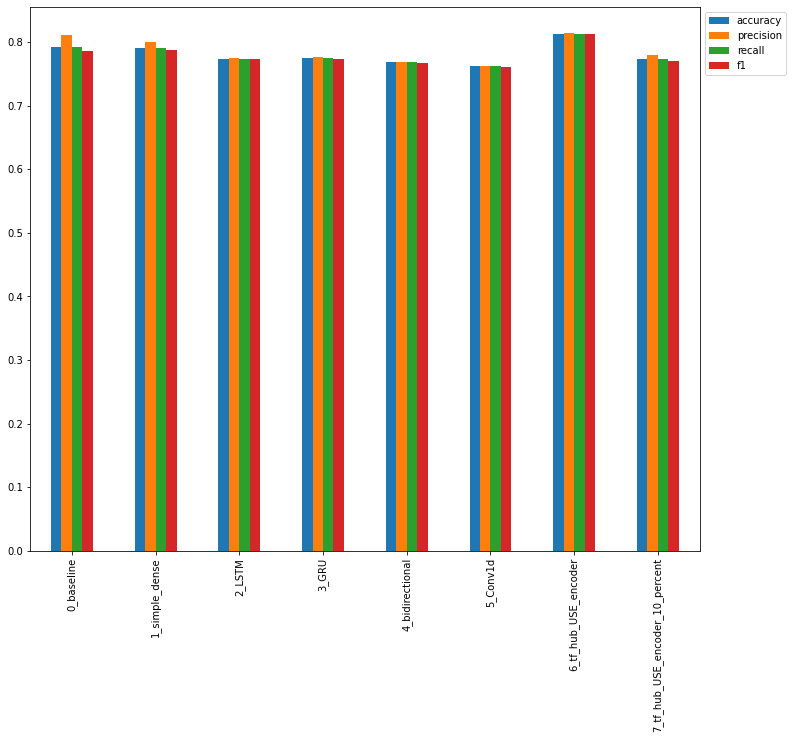

In [148]:
#PLot and compare all of the model results
all_model_results.plot(kind='bar', figsize=(12,10)).legend(bbox_to_anchor=(1.0,1.0));

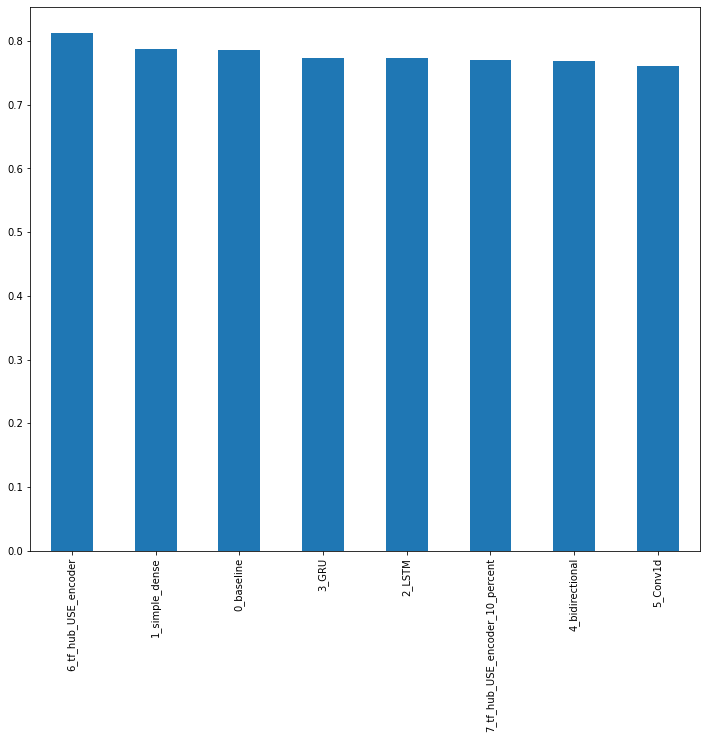

In [150]:
#sort model by f1score
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(12,10));

### Inspecting model using Tensorboard.dev

In [ ]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP Modelling Experiments" \
  --description "Comparing multiple different types of model architecture on the Kaggle Tweets text classification dataset" \
  --one_shot

Output of above cell hidden ,
you can check out the tensorboard here [https://tensorboard.dev/experiment/uQZxrZr1S5qen45HAtjRbw/ ](https://tensorboard.dev/experiment/uQZxrZr1S5qen45HAtjRbw/)

2nd day run here:

[2nd run](https://tensorboard.dev/experiment/uQZxrZr1S5qen45HAtjRbw/)

In [175]:
# !tensorboard dev list

----
----

## Saving the model

In [156]:
model_6.save('model_6.h5')

In [164]:
loaded_model_6 = tf.keras.models.load_model('model_6.h5', 
                                            custom_objects={'KerasLayer': hub.KerasLayer})

In [160]:
model_6.save('model_6_savemodel')

INFO:tensorflow:Assets written to: model_6_savemodel/assets


INFO:tensorflow:Assets written to: model_6_savemodel/assets


In [169]:
loaded_model_6 = tf.keras.models.load_model('model_6_savemodel')

In [170]:
loaded_model_6.evaluate(val_sentences,val_labels)

24/24 [==============================] - 1s 18ms/step - loss: 0.4292 - accuracy: 0.8136


[0.4291958510875702, 0.8136482834815979]

In [171]:
model_6_results

{'accuracy': 81.36482939632546,
 'f1': 0.8126248998925568,
 'precision': 0.8145308821695579,
 'recall': 0.8136482939632546}

---

## Finding the most wrong examples

what is the model getting wrong?

In [176]:
#pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2021-09-04 21:18:17--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.194.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  94.6MB/s    in 9.2s    

2021-09-04 21:18:26 (99.5 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variabl

In [177]:
model_6_pretrained = tf.keras.models.load_model('08_model_6_USE_feature_extractor')
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 18ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [178]:
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [180]:
# Creating a dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [184]:
#Finding the wrong predictions and sorting them by prediction probabilities
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob', ascending=False)
most_wrong[:10] # false postives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [185]:
most_wrong.tail() #false negatives

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


A reminder:

0 = Not a real disaster Tweet

1 = Real disaster Tweet

In [187]:
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8523000478744507
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Prob: 0.8272134065628052
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0,

In [189]:
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.06730344146490097
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0, Prob: 0.05507582053542137
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.05460338667035103
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.05459698289632797
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.04963728412985802
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0, Prob: 0.042086832225322

In [199]:
## Making predictions on the test dataset
test_sentences = test_df['text'].to_list()
test_samples = random.sample(test_sentences, 15)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

Pred: 1, Prob: 0.8459351062774658
Text:
Investigators say a fatal Virgin Galactic spaceship crash last year was caused by structural failure after the co-pilot unlocked a braking

----

Pred: 1, Prob: 0.8527684211730957
Text:
Attention Service Members Veterans Educators First Responders in Jacksonville FL http://t.co/4UrtBEAcE5

----

Pred: 1, Prob: 0.9070614576339722
Text:
2 Injured 1 missing in bridge collapse in central Mexico http://t.co/scDa8eVwR6

----

Pred: 0, Prob: 0.12346201390028
Text:
@rewind_music found out about you guys today(regarding the accident on the airplane lol) &amp; became a fan! Sending love &amp; support from Cali~?

----

Pred: 0, Prob: 0.10247066617012024
Text:
@AlbertBreer he was probably annihilated needed his DD

----

Pred: 0, Prob: 0.036669641733169556
Text:
Trying to get higher in the bathroom at work with my pen b4 I go and demolish my food ??????

----

Pred: 0, Prob: 0.06444902718067169
Text:
If you're lost and alone
Or you're sinking like a stone.


## Predicting on tweets from the wild (random tweets)

In [210]:
my_tweet = "Milwaukee Bucks are the 2021 NBA champions"

In [211]:
def predict_on_sentence(model, sentence):
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [215]:
predict_on_sentence(model_6, my_tweet)

Pred: 0.0 (not real disaster) Prob: 0.09315870702266693
Text:
Milwaukee Bucks are the 2021 NBA champions


----

## The Speed/Score Tradeoff

In [216]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [217]:
# Calc tfhub encoder time per prediction
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6_pretrained, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.3651867119997405, 0.00047924765354296657)

In [218]:
# Calc baseline model time per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.025159652000183996, 3.301791601074015e-05)

The total pred time is about 10x less in the baseline model

In [219]:
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'f1': 0.8148082644367335,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651}

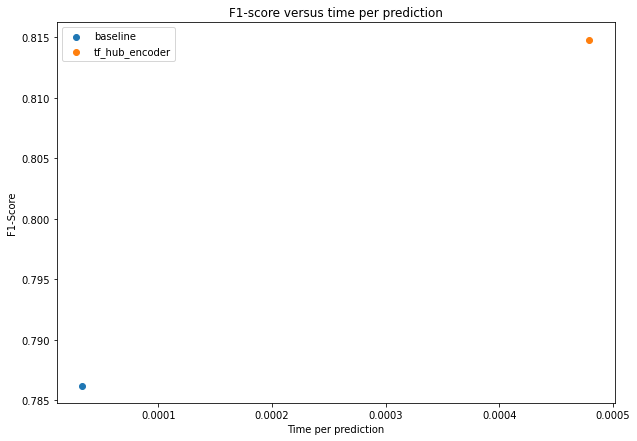

In [223]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(baseline_time_per_pred, baseline_results['f1'], label='baseline')
plt.scatter(model_6_time_per_pred, model_6_pretrained_results['f1'], label='tf_hub_encoder')
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");

### Keep this Tradeoff in mind while implenting models in machine-learning powered application **

-----
-----
------